In [ ]:
from pyopenms import *
import matplotlib.pyplot as plt

In [ ]:
protein_ids = []
peptide_ids = []
SimpleSearchEngineAlgorithm().search("Fusion_180220_07.mzML", "Scerevisiae_UPS2_1802.fasta", protein_ids, peptide_ids)

In [ ]:
exp = MSExperiment()
MzMLFile().load("Fusion_180220_07.mzML", exp)
filtered = MSExperiment()
for s in exp:
    if s.getMSLevel() == 2:
        filtered.addSpectrum(s)

In [ ]:
def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
            obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
            theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
            plt.figure(figsize=(12,8))
            plt.bar(obs_mz, obs_int, width = 3.0)
            plt.bar(theo_mz, theo_int, width = 3.0)
            plt.title(title)
            plt.ylabel('intensity')
            plt.xlabel('m/z')

In [5]:
# Peptide identification values
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for peptide_id in peptide_ids[:101]:
    print (35*"=")
    print ("Peptide scan index:", peptide_id.getMetaValue("scan_index"))
    print ("Peptide ID m/z:", peptide_id.getMZ())
#PeptideHits
    for hit in peptide_id.getHits():
        print(" - Peptide hit rank:", hit.getRank())
        print(" - Peptide hit sequence:", hit.getSequence())
        print(" - Peptide hit score:", hit.getScore())

        spectra = filtered.getSpectrum(peptide_id.getMetaValue("scan_index"))
        tsg = TheoreticalSpectrumGenerator()
        thspec = MSSpectrum()
        p = Param()
        p.setValue("add_metainfo", "true")
        tsg.setParameters(p)
        peptide = AASequence.fromString(hit.getSequence().toString())
        tsg.getSpectrum(thspec, peptide, 1, 2)
        
        # Spectrum alignment
        alignment = []
        spa = SpectrumAlignment()
        p = spa.getParameters()
        
        p.setValue("tolerance", 0.5)
        p.setValue("is_relative_tolerance", "false")
        spa.setParameters(p)

        spa.getSpectrumAlignment(alignment, thspec, spectra)

        print("matched peptide"+"\t"+peptide.toString()+"\t"+"Number of matched peaks: " + str(len(alignment)))
        print("ion\ttheo. m/z\tobserved m/z")
        for theo_idx, obs_idx in alignment:
            ion_name = thspec.getStringDataArrays()[0][theo_idx].decode()
            ion_charge = thspec.getIntegerDataArrays()[0][theo_idx]
            print(ion_name + "\t" + str(ion_charge) + "\t"
                  + str(thspec[theo_idx].getMZ())
                  + "\t" + str(spectra[obs_idx].getMZ()))

        
        for theo_idx, obs_idx in alignment:
            theo_mz.append(thspec[theo_idx].getMZ())
            theo_int.append(thspec[theo_idx].getIntensity())
            obs_mz.append(spectra[obs_idx].getMZ())
            obs_int.append(spectra[obs_idx].getIntensity())

Peptide scan index: 2
Peptide ID m/z: 621.786560058594
 - Peptide hit rank: 1
 - Peptide hit sequence: GFQLEFEDEK
 - Peptide hit score: 0.002217645524069667
matched peptide	GFQLEFEDEK	Number of matched peaks: 5
ion	theo. m/z	observed m/z
b5++	2	288.14483407287105	288.40411376953125
b8++	2	483.7138104078211	483.3984069824219
y4+	1	520.224937519471	520.05517578125
b9++	2	548.2351075194711	547.8553466796875
y5+	1	667.2933518065711	667.2887573242188
Peptide scan index: 9
Peptide ID m/z: 570.805114746094
 - Peptide hit rank: 1
 - Peptide hit sequence: NVSGPSTTLHK
 - Peptide hit score: 0.0004505576507654041
matched peptide	NVSGPSTTLHK	Number of matched peaks: 15
ion	theo. m/z	observed m/z
b6++	2	271.632091025021	271.2270202636719
y5++	2	300.179208200471	300.4296875
b7++	2	322.155930636671	321.94610595703125
y3+	1	397.255781487571	397.39996337890625
y8++	2	420.732336939721	421.10589599609375
b9++	2	429.221802423771	428.975341796875
b5+	1	455.224876423771	454.96807861328125
y9++	2	464.24835151

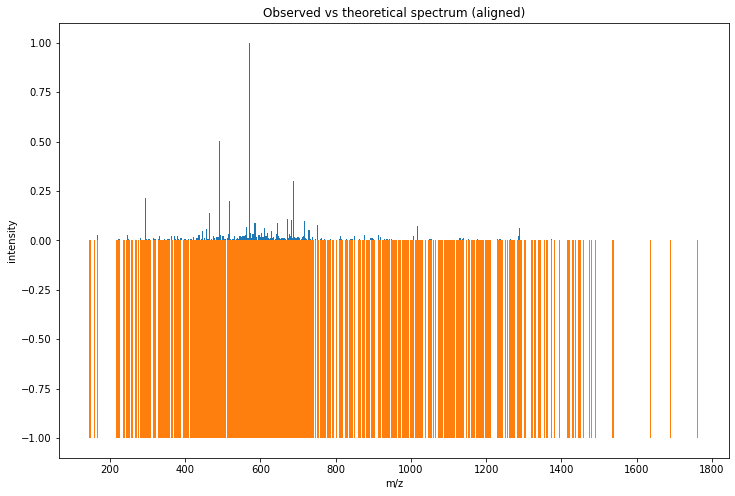

In [6]:
title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)